In [14]:
from argparse import Namespace
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import pprint

In [15]:
def set_seeds(seed,cuda):
    np.random.seed(seed)# when use np.random.rand() or np.random.randn()
    torch.manual_seed(seed)# when use torch.rand() or torch.randn()
    if cuda:
        torch.cuda.manual_seed_all(seed)

In [16]:
args = Namespace(
    seed = 999,
    cuda = True,
    shuffle = True,
    data_file = "tumors.csv",
    reduced_data_file = "tumors_reduced.csv",
    train_size = 0.75,
    test_size = 0.25,
    num_hidden_units = 100,
    learning_rate = 1e-3,
    num_epochs = 100,
)

In [17]:
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")

In [18]:
set_seeds(seed = args.seed,cuda=args.cuda)
pprint.pprint(vars(args),indent=4)
print(args.device)

{   'cuda': True,
    'data_file': 'tumors.csv',
    'device': device(type='cuda'),
    'learning_rate': 0.001,
    'num_epochs': 100,
    'num_hidden_units': 100,
    'reduced_data_file': 'tumors_reduced.csv',
    'seed': 999,
    'shuffle': True,
    'test_size': 0.25,
    'train_size': 0.75}
cuda


In [19]:
import re
import urllib

In [21]:
url = "https://raw.githubusercontent.com/LisonEvf/practicalAI-cn/master/data/tumors.csv"
response = urllib.request.urlopen(url)
html = response.read()# 2 btypes
# wb : write as binary
with open(args.data_file, "wb") as fp:
    fp.write(html)

In [23]:
df = pd.read_csv(args.data_file,header = 0)
df.head(10)

,leukocyte_count,blood_pressure,tumor
0,13.472969,15.250393,1
1,10.805510,14.109676,1
2,13.834053,15.793920,1
3,9.572811,17.873286,1
4,7.633667,16.598559,1
5,12.795534,16.021330,1
6,12.885377,15.402248,1
7,16.048327,16.059701,1
8,13.486377,14.691901,1
9,9.438947,17.223709,1


In [26]:
def plot_tumors(df):
    i = 0
    colors = ['r','b']
    for name, group in df.groupby("tumor"):
        # name = 0, group is Benign data, name = 1, group is Malignant data
        plt.scatter(group.leukocyte_count, group.blood_pressure, edgecolors='k',
                   color=colors[i]); i += 1
    plt.xlabel("leukocyte_count")
    plt.ylabel("blood_pressure")
    plt.legend(['0 - benign', '1 - malignant'], loc="upper right")
    plt.show()
        

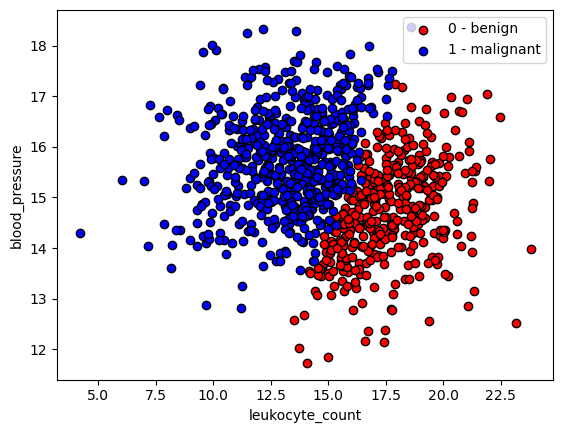

In [27]:
plot_tumors(df)

In [34]:
X = df[['leukocyte_count', 'blood_pressure']].values
y = df[['tumor']].values

X = torch.from_numpy(X).float()
y = torch.from_numpy(y.ravel()).long()

In [35]:

y1 = np.array([[4], [3], [2]])
print("y1.shape:", y1.shape)  # (3, 1)
print("y1:", y1)  
y2 = y1.ravel()
print("y2.shape:", y2.shape)  # (3,)
print("y2:", y2)  # [4 3 2]


y1.shape: (3, 1)
y1: [[4]
 [3]
 [2]]
y2.shape: (3,)
y2: [4 3 2]


In [37]:
shuffle_index = torch.LongTensor(random.sample(range(0,len(X)),len(X)))
X = X[shuffle_index]
y = y[shuffle_index]

test_start_index = int(len(X) * args.train_size)
X_train  =  X[:test_start_index]
y_train = y[:test_start_index]
X_test = X[test_start_index:]
y_test = y[test_start_index:]

print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))


We have 750 train samples and 250 test samples.


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [39]:
class MLP(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(input_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,output_dim)
    def forward(self,x_in,apply_softmax = False):
        a1 = F.relu(self.fc1(x_in))
        y_pred = self.fc2(a1)
        if apply_softmax:
            y_pred = F.softmax(y_pred,dim=1)
        return y_pred

In [42]:
model = MLP(input_dim=len(df.columns)-1,
            hidden_dim=args.num_hidden_units,
            output_dim=len(set(df.tumor)))# set get the number of tumor kind

loss_fn = nn.CrossEntropyLoss()
optimzer = optim.Adam(model.parameters(),lr=args.learning_rate)
            

In [43]:
def get_accuracy(y_pred,y_target):
    n_correct = torch.eq(y_pred,y_target).sum().item()
    acc = n_correct / len(y_pred) * 100
    return acc
    

In [48]:
for t in range (args.num_epochs):
    y_pred = model(X_train)
    _,predictions = y_pred.max(dim = 1)
    acc = get_accuracy(y_pred=predictions.long(),y_target=y_train)
    loss = loss_fn(y_pred,y_train)
    if t%20==0: 
        print ("epoch: {0} | loss: {1:.4f} | accuracy: {2:.1f}%".format(t, loss, acc))
    optimzer.zero_grad()
    loss.backward()
    optimzer.step()

epoch: 0 | loss: 0.0634 | accuracy: 98.8%
epoch: 20 | loss: 0.0616 | accuracy: 98.8%
epoch: 40 | loss: 0.0600 | accuracy: 98.8%
epoch: 60 | loss: 0.0585 | accuracy: 98.8%
epoch: 80 | loss: 0.0571 | accuracy: 98.8%


In [49]:
_,pred_train = model(X_train,apply_softmax = True).max(dim = 1)
train_acc = get_accuracy(y_pred=pred_train,y_target=y_train)

_,pred_test = model(X_test,apply_softmax = True).max(dim = 1)
test_acc = get_accuracy(y_pred=pred_test,y_target=y_test)

print("train acc:{0:.1f}%, test acc: {1:.1f}%".format(train_acc,test_acc))

train acc:98.8%, test acc: 98.0%


In [50]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral
    
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

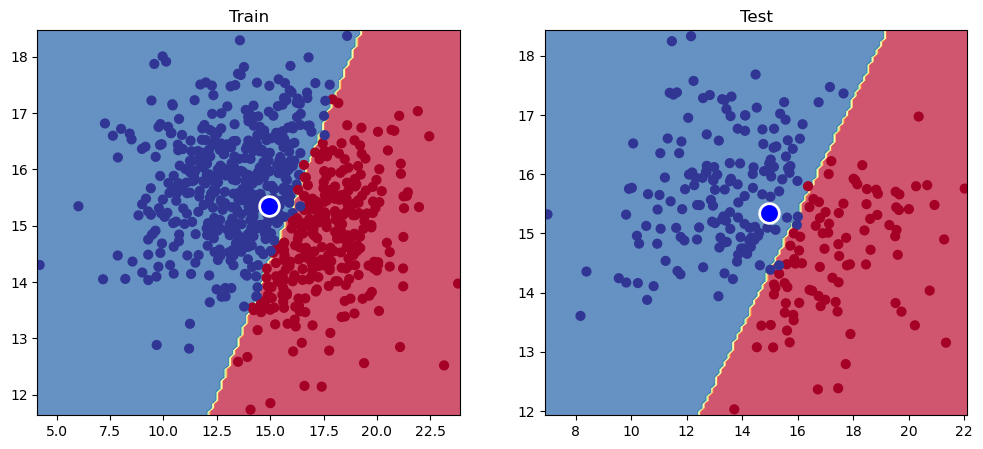

In [51]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200, 
            c='b', edgecolor='w', linewidth=2)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200, 
            c='b', edgecolor='w', linewidth=2)
plt.show()
    